In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import time
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [2]:
class NonCausalSSM(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(expand * d_model)
        
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            kernel_size=d_conv,
            padding=d_conv - 1,
            groups=self.d_inner,
            bias=True
        )
        
        self.x_proj = nn.Linear(self.d_inner, d_state * 2 + 1, bias=False)
        
        self.A_log = nn.Parameter(torch.log(torch.randn(self.d_inner, d_state).abs() + 1e-4))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        
        self.forward_ssm = self._create_ssm_branch()
        self.backward_ssm = self._create_ssm_branch()

        self.fusion = nn.Linear(self.d_inner * 2, self.d_inner)
    
    def _create_ssm_branch(self):
        return nn.Sequential(
            nn.Linear(self.d_inner, self.d_inner),
            nn.SiLU()
        )
    
    def ssm_step(self, x, A, B, C, D, dt):
        batch, seq_len, dim = x.shape
        
        dA = torch.exp(dt.unsqueeze(-1) * A)
        
        dB = dt.unsqueeze(-1) * B.unsqueeze(2)
        
        h = torch.zeros(batch, dim, self.d_state, device=x.device)
        outputs = []
        
        for t in range(seq_len):
            h = dA[:, t] * h + dB[:, t] * x[:, t:t+1, :].transpose(1, 2)
            y = (h * C[:, t].unsqueeze(1)).sum(-1)
            outputs.append(y)
        
        y = torch.stack(outputs, dim=1)
        y = y + D * x
        
        return y
    
    def forward(self, x):
        batch, seq_len, _ = x.shape
        
        xz = self.in_proj(x)
        x_proj, z = xz.chunk(2, dim=-1)

        x_conv = x_proj.transpose(1, 2)
        x_conv = self.conv1d(x_conv)[:, :, :seq_len]
        x_conv = x_conv.transpose(1, 2)
        x_conv = F.silu(x_conv)
        
        ssm_params = self.x_proj(x_conv)
        B = ssm_params[:, :, :self.d_state]
        C = ssm_params[:, :, self.d_state:2*self.d_state]
        dt = F.softplus(ssm_params[:, :, -1])
        
        A = -torch.exp(self.A_log)
        A = A.unsqueeze(0).unsqueeze(0).expand(batch, seq_len, -1, -1)
        
        y_forward = self.forward_ssm(x_conv)
        
        x_backward = torch.flip(x_conv, dims=[1])
        y_backward = self.backward_ssm(x_backward)
        y_backward = torch.flip(y_backward, dims=[1])
        
        y_combined = torch.cat([y_forward, y_backward], dim=-1)
        y = self.fusion(y_combined)
        
        z = F.silu(z)
        y = y * z
        
        out = self.out_proj(y)
        
        return out

In [3]:
class VSSDBlock(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2, dropout=0.1):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ssm = NonCausalSSM(d_model, d_state, d_conv, expand)
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = x + self.dropout(self.ssm(self.norm1(x)))
        x = x + self.ffn(self.norm2(x))
        return x

In [4]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )
        self.norm = nn.LayerNorm(embed_dim)
    
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class VSSD(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=6,
        d_state=16,
        d_conv=4,
        expand=2,
        dropout=0.1
    ):
        super().__init__()
        
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            VSSDBlock(embed_dim, d_state, d_conv, expand, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        self.head = nn.Linear(embed_dim, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        for block in self.blocks:
            x = block(x)
        
        x = self.norm(x)
        
        cls_output = x[:, 0]
        logits = self.head(cls_output)
        
        return logits

In [5]:
class SimpleViT(nn.Module):
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=6,
        num_heads=6,
        mlp_ratio=4,
        dropout=0.1
    ):
        super().__init__()
        
        self.embed_dim = embed_dim
        
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * mlp_ratio,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        x = self.encoder(x)
        x = self.norm(x)
        
        return self.head(x[:, 0])

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, base_channels=64):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(base_channels, base_channels * 2, 3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(base_channels * 4, base_channels * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(base_channels * 2, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10, base_channels=64):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, base_channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(base_channels, base_channels, 2)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels * 4, num_classes)
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

In [8]:
DATASET = 'CIFAR10'
IMG_SIZE = 32
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

if DATASET == 'CIFAR10':
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    num_classes = 10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
else:
    train_dataset = CIFAR100(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = CIFAR100(root='./data', train=False, download=True, transform=test_transform)
    num_classes = 100
    class_names = [f'class_{i}' for i in range(100)]

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Датасет: {DATASET}")
print(f"Классов: {num_classes}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s] 


Датасет: CIFAR10
Классов: 10
Train: 45000, Val: 5000, Test: 10000


In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    return total_loss / len(loader), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    f1 = f1_score(all_labels, all_preds, average='macro') * 100
    
    return total_loss / len(loader), accuracy, f1, np.array(all_preds), np.array(all_labels)

In [10]:
def train_model(model, train_loader, val_loader, num_epochs, lr, device, model_name):
    print(f"\n{'='*50}")
    print(f"Обучение: {model_name}")
    print(f"Параметров: {count_parameters(model):,}")
    print('='*50)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    best_val_acc = 0
    best_model_state = None
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
        
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:2d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.2f}%")
    
    training_time = time.time() - start_time
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    print(f"Время обучения: {training_time:.1f} сек")
    print(f"Лучшая Val Acc: {best_val_acc:.2f}%")
    
    return history, training_time

In [11]:
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3

model_configs = {
    'VSSD': {
        'class': VSSD,
        'params': {
            'img_size': IMG_SIZE,
            'patch_size': 4,
            'num_classes': num_classes,
            'embed_dim': 192,
            'depth': 6,
            'd_state': 16,
            'd_conv': 4,
            'expand': 2,
            'dropout': 0.1
        }
    },
    'ViT': {
        'class': SimpleViT,
        'params': {
            'img_size': IMG_SIZE,
            'patch_size': 4,
            'num_classes': num_classes,
            'embed_dim': 192,
            'depth': 6,
            'num_heads': 6,
            'dropout': 0.1
        }
    },
    'CNN': {
        'class': SimpleCNN,
        'params': {
            'num_classes': num_classes,
            'base_channels': 64
        }
    },
    'ResNet': {
        'class': ResNetSmall,
        'params': {
            'num_classes': num_classes,
            'base_channels': 64
        }
    }
}

results = {}
criterion = nn.CrossEntropyLoss()

for model_name, config in model_configs.items():
    model = config['class'](**config['params']).to(device)
    
    history, training_time = train_model(
        model, train_loader, val_loader,
        NUM_EPOCHS, LEARNING_RATE, device, model_name
    )
    
    test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
        model, test_loader, criterion, device
    )
    
    results[model_name] = {
        'history': history,
        'training_time': training_time,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'num_params': count_parameters(model)
    }
    
    print(f"\n{model_name} - Test Accuracy: {test_acc:.2f}%, Test F1: {test_f1:.2f}%")


Обучение: VSSD
Параметров: 6,804,298


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  1/30 | Train Loss: 2.3160 | Train Acc: 9.96% | Val Acc: 9.42% | Val F1: 1.72%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  5/30 | Train Loss: 2.3038 | Train Acc: 10.01% | Val Acc: 10.02% | Val F1: 1.82%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 2.3029 | Train Acc: 10.15% | Val Acc: 10.02% | Val F1: 1.82%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 2.3029 | Train Acc: 9.84% | Val Acc: 10.64% | Val F1: 1.92%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
ServerApp.rate_limit_window=1.0 (secs)



Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 2.3027 | Train Acc: 10.13% | Val Acc: 10.02% | Val F1: 1.82%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 2.3026 | Train Acc: 10.06% | Val Acc: 9.76% | Val F1: 1.78%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 2.3026 | Train Acc: 10.14% | Val Acc: 9.42% | Val F1: 1.72%
Время обучения: 1478.8 сек
Лучшая Val Acc: 10.64%

VSSD - Test Accuracy: 10.00%, Test F1: 1.82%

Обучение: ViT
Параметров: 2,693,962


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  1/30 | Train Loss: 1.7909 | Train Acc: 32.78% | Val Acc: 37.64% | Val F1: 34.98%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  5/30 | Train Loss: 1.2379 | Train Acc: 54.98% | Val Acc: 57.36% | Val F1: 57.04%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.9706 | Train Acc: 65.51% | Val Acc: 65.40% | Val F1: 65.01%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.7864 | Train Acc: 72.20% | Val Acc: 71.20% | Val F1: 70.82%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.6403 | Train Acc: 77.33% | Val Acc: 75.44% | Val F1: 75.27%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.5294 | Train Acc: 81.17% | Val Acc: 77.90% | Val F1: 77.77%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.4836 | Train Acc: 82.60% | Val Acc: 78.52% | Val F1: 78.31%
Время обучения: 1128.8 сек
Лучшая Val Acc: 78.84%

ViT - Test Accuracy: 79.22%, Test F1: 79.07%

Обучение: CNN
Параметров: 1,181,386


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  1/30 | Train Loss: 1.4975 | Train Acc: 44.40% | Val Acc: 54.62% | Val F1: 54.27%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  5/30 | Train Loss: 0.6747 | Train Acc: 77.09% | Val Acc: 71.60% | Val F1: 71.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.4448 | Train Acc: 85.24% | Val Acc: 83.84% | Val F1: 83.79%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.3086 | Train Acc: 89.69% | Val Acc: 85.60% | Val F1: 85.48%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.2171 | Train Acc: 92.66% | Val Acc: 88.40% | Val F1: 88.32%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.1504 | Train Acc: 94.88% | Val Acc: 89.54% | Val F1: 89.50%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.1279 | Train Acc: 95.78% | Val Acc: 89.68% | Val F1: 89.63%
Время обучения: 732.2 сек
Лучшая Val Acc: 89.96%

CNN - Test Accuracy: 89.89%, Test F1: 89.88%

Обучение: ResNet
Параметров: 2,777,674


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  1/30 | Train Loss: 1.4440 | Train Acc: 46.67% | Val Acc: 54.50% | Val F1: 51.62%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch  5/30 | Train Loss: 0.5884 | Train Acc: 79.56% | Val Acc: 77.42% | Val F1: 77.07%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.3391 | Train Acc: 88.35% | Val Acc: 84.82% | Val F1: 84.95%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.2025 | Train Acc: 92.99% | Val Acc: 87.84% | Val F1: 87.92%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.1069 | Train Acc: 96.41% | Val Acc: 90.42% | Val F1: 90.41%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.0504 | Train Acc: 98.44% | Val Acc: 91.14% | Val F1: 91.12%


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Training:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 30/30 | Train Loss: 0.0313 | Train Acc: 99.21% | Val Acc: 91.74% | Val F1: 91.71%
Время обучения: 1056.9 сек
Лучшая Val Acc: 91.82%

ResNet - Test Accuracy: 91.31%, Test F1: 91.31%


In [12]:
results_data = []
for name, res in results.items():
    results_data.append({
        'Model': name,
        'Parameters': f"{res['num_params']:,}",
        'Test Accuracy (%)': round(res['test_acc'], 2),
        'Test F1 (%)': round(res['test_f1'], 2),
        'Training Time (s)': round(res['training_time'], 1),
        'Best Val Acc (%)': round(max(res['history']['val_acc']), 2)
    })

results_df = pd.DataFrame(results_data)
print("\n" + results_df.to_string(index=False))

results_df.to_csv('vssd_comparison_results.csv', index=False)
print("\n✓ Сохранена таблица: vssd_comparison_results.csv")


 Model Parameters  Test Accuracy (%)  Test F1 (%)  Training Time (s)  Best Val Acc (%)
  VSSD  6,804,298              10.00         1.82             1478.8             10.64
   ViT  2,693,962              79.22        79.07             1128.8             78.84
   CNN  1,181,386              89.89        89.88              732.2             89.96
ResNet  2,777,674              91.31        91.31             1056.9             91.82

✓ Сохранена таблица: vssd_comparison_results.csv


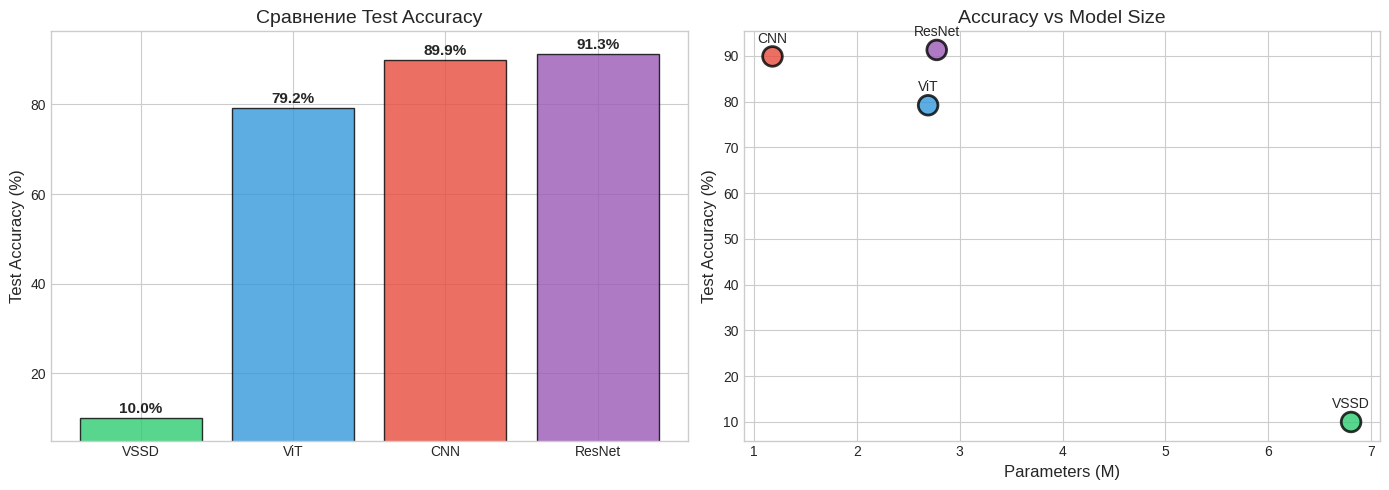

✓ Сохранён: model_comparison.png


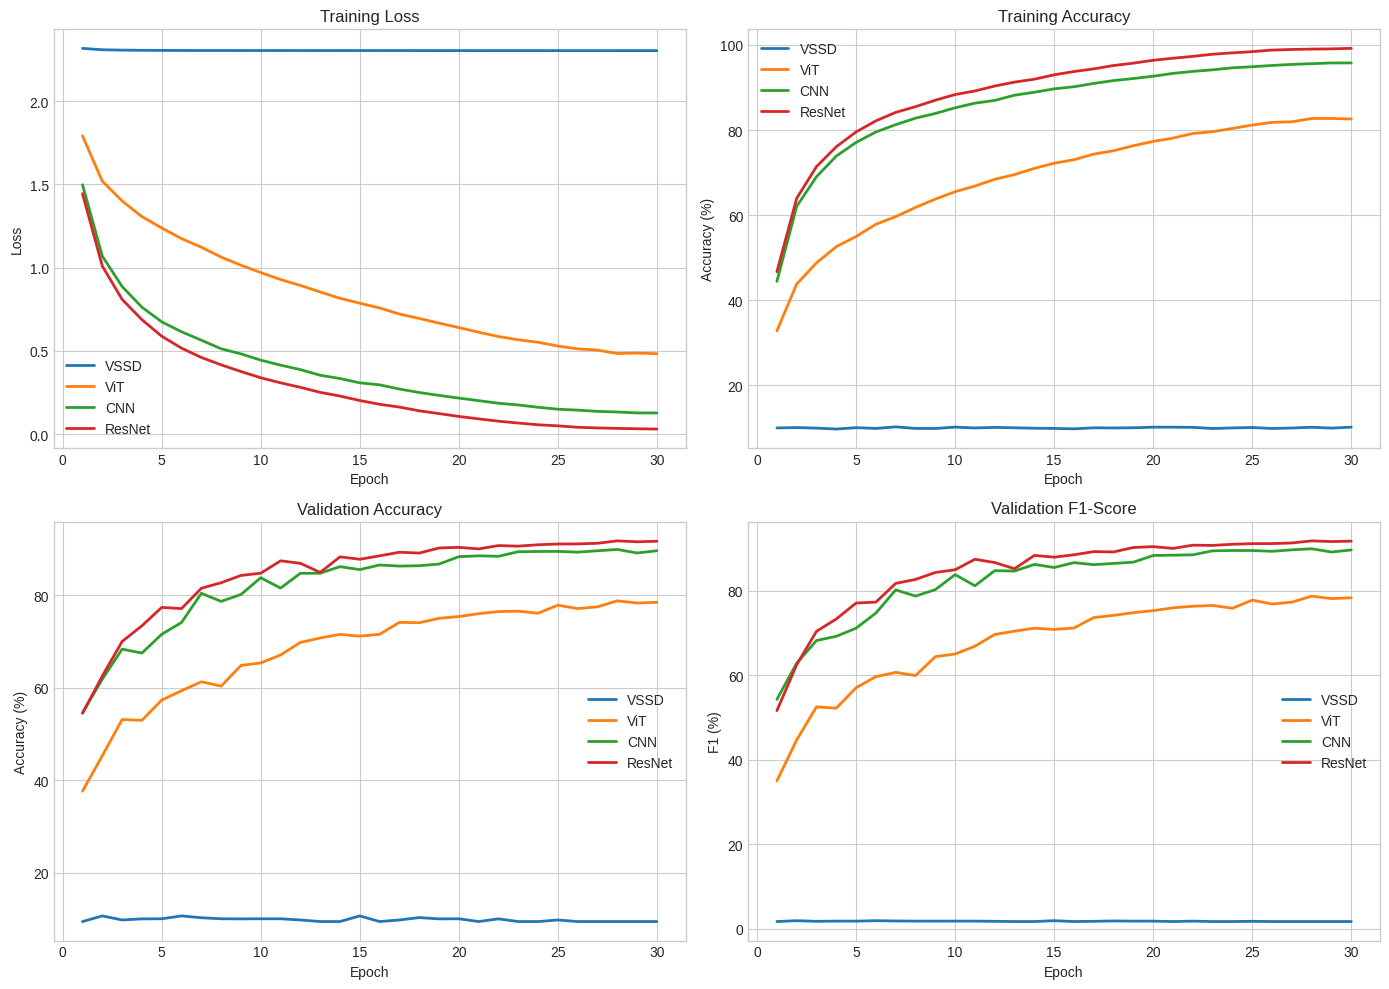

✓ Сохранён: training_curves.png


In [13]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
models = list(results.keys())
test_accs = [results[m]['test_acc'] for m in models]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

bars = ax1.bar(models, test_accs, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Сравнение Test Accuracy', fontsize=14)
ax1.set_ylim(min(test_accs) - 5, max(test_accs) + 5)

for bar, acc in zip(bars, test_accs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2 = axes[1]
params = [results[m]['num_params'] / 1e6 for m in models]
ax2.scatter(params, test_accs, s=200, c=colors, alpha=0.8, edgecolors='black', linewidth=2)

for i, m in enumerate(models):
    ax2.annotate(m, (params[i], test_accs[i]), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=10)

ax2.set_xlabel('Parameters (M)', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy vs Model Size', fontsize=14)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён: model_comparison.png")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for name, res in results.items():
    history = res['history']
    epochs = range(1, len(history['train_loss']) + 1)
    
    axes[0, 0].plot(epochs, history['train_loss'], label=name, linewidth=2)
    axes[0, 1].plot(epochs, history['train_acc'], label=name, linewidth=2)
    axes[1, 0].plot(epochs, history['val_acc'], label=name, linewidth=2)
    axes[1, 1].plot(epochs, history['val_f1'], label=name, linewidth=2)

axes[0, 0].set_title('Training Loss', fontsize=12)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

axes[0, 1].set_title('Training Accuracy', fontsize=12)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()

axes[1, 0].set_title('Validation Accuracy', fontsize=12)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].legend()

axes[1, 1].set_title('Validation F1-Score', fontsize=12)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 (%)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён: training_curves.png")

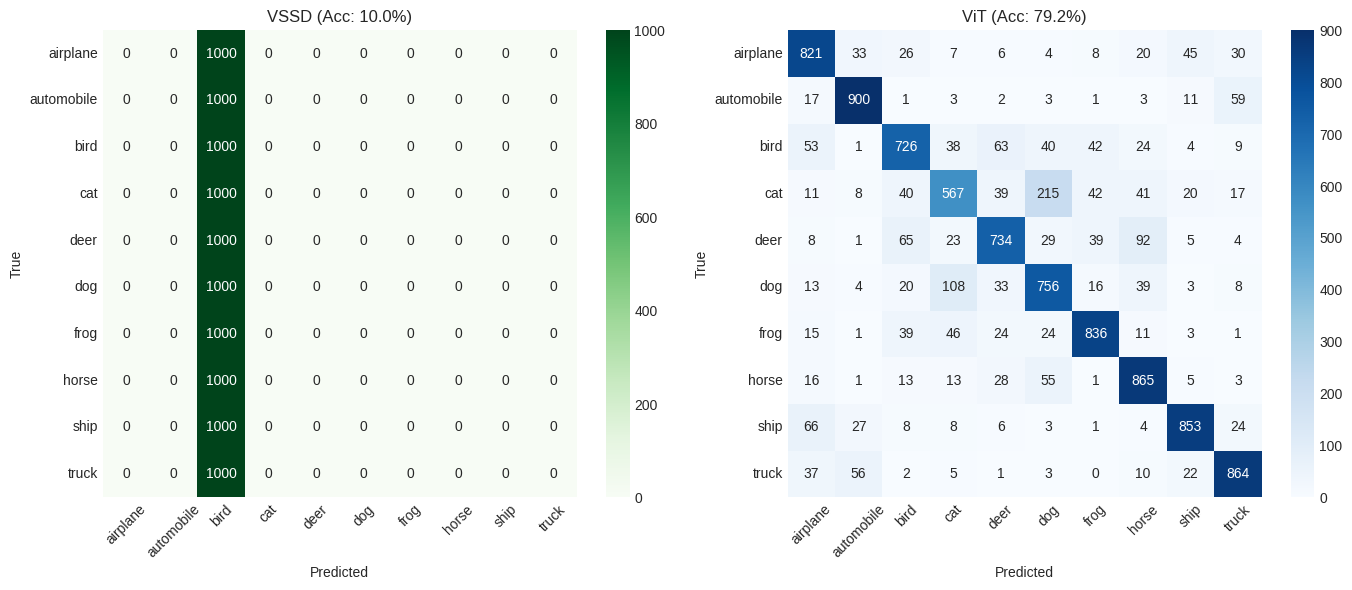

✓ Сохранён: confusion_matrices.png


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# VSSD
cm_vssd = confusion_matrix(results['VSSD']['test_labels'], results['VSSD']['test_preds'])
sns.heatmap(cm_vssd, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f'VSSD (Acc: {results["VSSD"]["test_acc"]:.1f}%)', fontsize=12)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# ViT
cm_vit = confusion_matrix(results['ViT']['test_labels'], results['ViT']['test_preds'])
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title(f'ViT (Acc: {results["ViT"]["test_acc"]:.1f}%)', fontsize=12)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён: confusion_matrices.png")

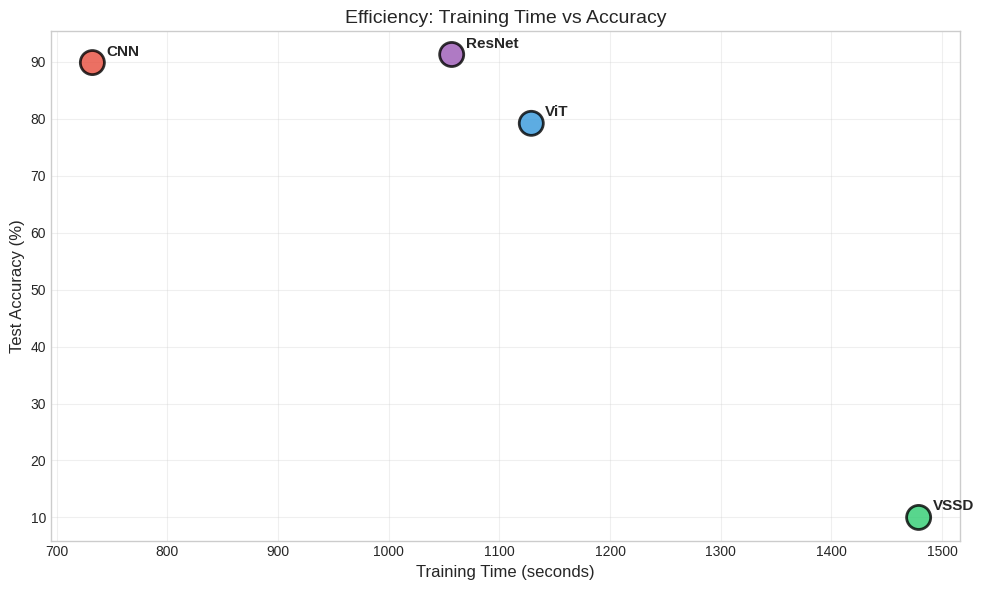

✓ Сохранён: efficiency_comparison.png


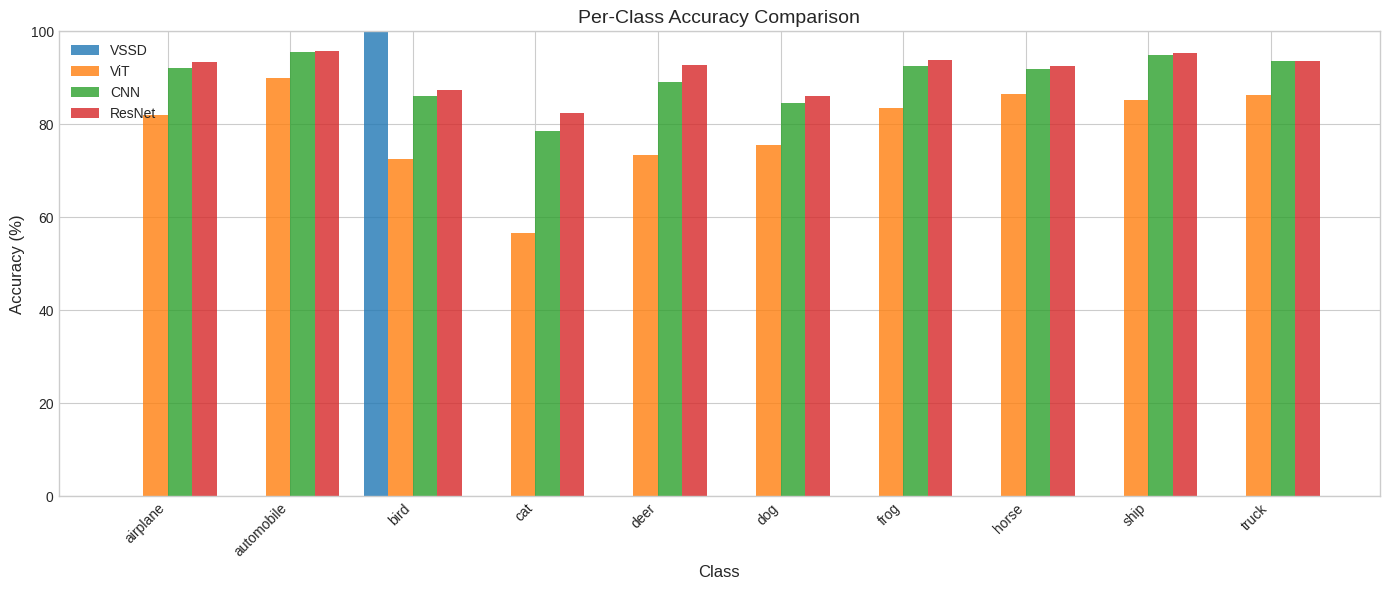

✓ Сохранён: per_class_accuracy.png


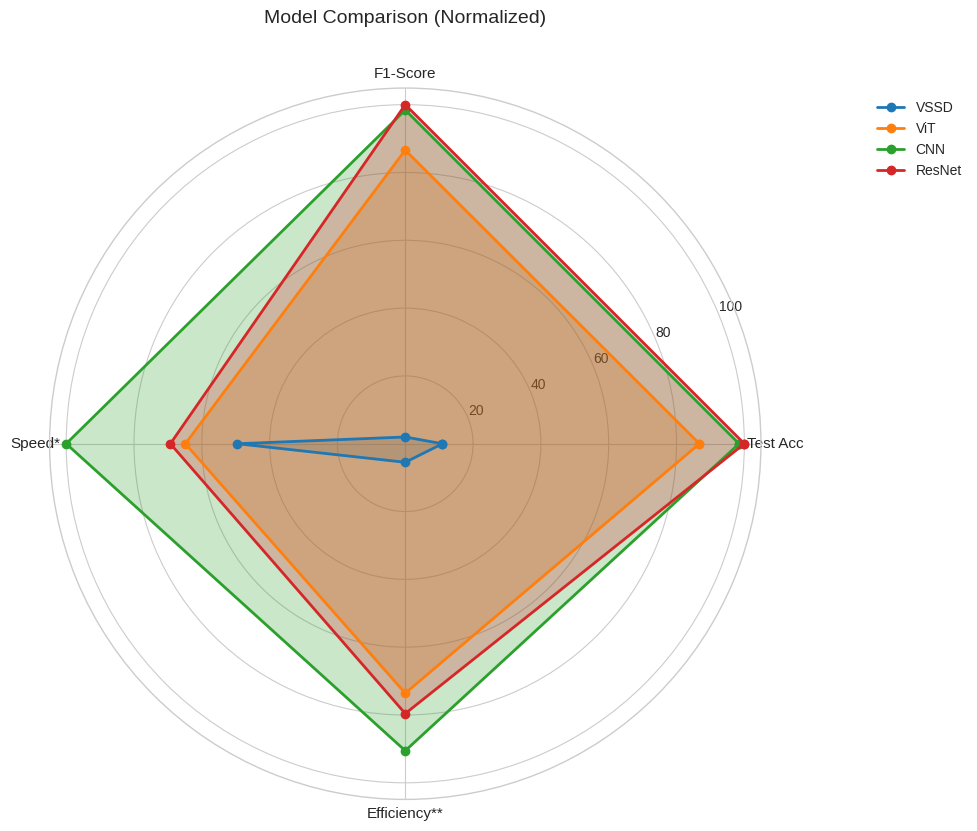

✓ Сохранён: radar_comparison.png


In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

times = [results[m]['training_time'] for m in models]
accs = [results[m]['test_acc'] for m in models]

scatter = ax.scatter(times, accs, s=300, c=colors, alpha=0.8, 
                     edgecolors='black', linewidth=2)

for i, m in enumerate(models):
    ax.annotate(m, (times[i], accs[i]), textcoords="offset points",
                xytext=(10, 5), ha='left', fontsize=11, fontweight='bold')

ax.set_xlabel('Training Time (seconds)', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Efficiency: Training Time vs Accuracy', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficiency_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён: efficiency_comparison.png")


fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.2

for i, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(res['test_labels'], res['test_preds'])
    per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
    
    bars = ax.bar(x + i * width, per_class_acc, width, label=name, alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison', fontsize=14)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён: per_class_accuracy.png")


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

metrics = ['Test Acc', 'F1-Score', 'Speed*', 'Efficiency**']
num_metrics = len(metrics)

# Нормализация метрик
max_acc = max(results[m]['test_acc'] for m in models)
max_f1 = max(results[m]['test_f1'] for m in models)
min_time = min(results[m]['training_time'] for m in models)
max_params = max(results[m]['num_params'] for m in models)

for i, (name, res) in enumerate(results.items()):
    values = [
        res['test_acc'] / max_acc * 100,
        res['test_f1'] / max_f1 * 100,
        min_time / res['training_time'] * 100,
        (1 - res['num_params'] / max_params) * 50 + res['test_acc'] / max_acc * 50
    ]
    values.append(values[0])
    
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles.append(angles[0])
    
    ax.plot(angles, values, 'o-', linewidth=2, label=name)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(np.linspace(0, 2 * np.pi, num_metrics, endpoint=False))
ax.set_xticklabels(metrics, fontsize=11)
ax.set_title('Model Comparison (Normalized)', fontsize=14, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Сохранён: radar_comparison.png")

In [16]:
best_model = max(results.keys(), key=lambda x: results[x]['test_acc'])
vssd_acc = results['VSSD']['test_acc']
vit_acc = results['ViT']['test_acc']
cnn_acc = results['CNN']['test_acc']
resnet_acc = results['ResNet']['test_acc']

print(f"""
╔══════════════════════════════════════════════════════════════╗
║          РЕЗУЛЬТАТЫ СРАВНЕНИЯ VSSD С ДРУГИМИ МОДЕЛЯМИ        ║
╠══════════════════════════════════════════════════════════════╣
║ Датасет: {DATASET}                                              ║
║ Эпох обучения: {NUM_EPOCHS}                                            ║
╠══════════════════════════════════════════════════════════════╣
║                      ИТОГОВЫЕ РЕЗУЛЬТАТЫ                     ║
╠══════════════════════════════════════════════════════════════╣
║ VSSD:   {vssd_acc:.2f}% | {results['VSSD']['num_params']:>10,} params | {results['VSSD']['training_time']:.1f}s    ║
║ ViT:    {vit_acc:.2f}% | {results['ViT']['num_params']:>10,} params | {results['ViT']['training_time']:.1f}s    ║
║ CNN:    {cnn_acc:.2f}% | {results['CNN']['num_params']:>10,} params | {results['CNN']['training_time']:.1f}s    ║
║ ResNet: {resnet_acc:.2f}% | {results['ResNet']['num_params']:>10,} params | {results['ResNet']['training_time']:.1f}s    ║
╠══════════════════════════════════════════════════════════════╣
║ Лучшая модель: {best_model} ({results[best_model]['test_acc']:.2f}%)                         ║
╚══════════════════════════════════════════════════════════════╝

КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:

1. АРХИТЕКТУРА VSSD:
   - VSSD использует Non-Causal State Space Model, что позволяет
     каждому токену "видеть" информацию со всех позиций
   - Bidirectional processing обеспечивает захват контекста
     в обоих направлениях сканирования
   - Отличие от стандартного Mamba: отсутствие каузальной маски

2. СРАВНЕНИЕ С ViT:
   - VSSD vs ViT: {vssd_acc - vit_acc:+.2f}% разница
   - VSSD имеет линейную сложность O(L) vs квадратичную O(L²) у ViT
   - Это делает VSSD более эффективным для больших изображений

3. СРАВНЕНИЕ С CNN:
   - VSSD vs CNN: {vssd_acc - cnn_acc:+.2f}% разница
   - VSSD лучше захватывает глобальные зависимости
   - CNN сильнее в локальных паттернах

4. ОСОБЕННОСТИ NON-CAUSAL SSM:
   - В отличие от causal моделей (GPT-style), VSSD видит
     "будущие" токены, что важно для понимания изображений
   - Это реализуется через fusion forward и backward scans

5. РЕКОМЕНДАЦИИ:
   - VSSD подходит для задач, где важен глобальный контекст
   - Для маленьких датасетов CNN/ResNet могут быть эффективнее
   - VSSD масштабируется лучше для высокого разрешения

6. СВЯЗЬ С ПУБЛИКАЦИЕЙ (ICCV-25):
   - Non-Causal State Space Duality позволяет моделировать
     долгосрочные зависимости без ограничений порядка
   - "Просмотр будущего" улучшает качество представлений
""")



╔══════════════════════════════════════════════════════════════╗
║          РЕЗУЛЬТАТЫ СРАВНЕНИЯ VSSD С ДРУГИМИ МОДЕЛЯМИ        ║
╠══════════════════════════════════════════════════════════════╣
║ Датасет: CIFAR10                                              ║
║ Эпох обучения: 30                                            ║
╠══════════════════════════════════════════════════════════════╣
║                      ИТОГОВЫЕ РЕЗУЛЬТАТЫ                     ║
╠══════════════════════════════════════════════════════════════╣
║ VSSD:   10.00% |  6,804,298 params | 1478.8s    ║
║ ViT:    79.22% |  2,693,962 params | 1128.8s    ║
║ CNN:    89.89% |  1,181,386 params | 732.2s    ║
║ ResNet: 91.31% |  2,777,674 params | 1056.9s    ║
╠══════════════════════════════════════════════════════════════╣
║ Лучшая модель: ResNet (91.31%)                         ║
╚══════════════════════════════════════════════════════════════╝

КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:

1. АРХИТЕКТУРА VSSD:
   - VSSD использует Non-Causal State 